## Imports

In [ ]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [207]:
def _connect_mongo(host, port, db):
    """ A util for making a connection to mongo """
    try:
        client = pymongo.MongoClient(host, port)
        client.server_info()
    except pymongo.errors.ServerSelectionTimeoutError as err:
        print(err)
        print("Are you sure your database is on and this can reach it?") 
        raise ConnectionError
    return client[db]


def read_mongo(db, collection, query={}, host='localhost', port=27017, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)
    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))
    # Delete the _id
    if no_id:
        del df['_id']

    return df
train_df = read_mongo("NETWORK", "train")
test_df = read_mongo("NETWORK", "test")

## Data Cleaning and Understanding

In [208]:
train_df.head(5)
print(len(train_df))

125973


In [209]:
test_df.head(5)
print(len(test_df))

22544


Our dataset have the same amount of features. Of these, protocol type, service, flag and attack are categorical.

### Check for NaNs

In [210]:
print(train_df.isnull().values.any())

False


### Check how the rest of the data looks like

In [211]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

We have a mix of ints, floats and strings. No null values that need to be cleand, however.

### Check string answer 

In [212]:
print(len(train_df["service"].drop_duplicates().values))
print(len(test_df["service"].drop_duplicates().values))
print("------------------------------------------------")
train_df["service"].drop_duplicates()

70
64
------------------------------------------------


0          ftp_data
1             other
2           private
3              http
8        remote_job
            ...    
11124     http_8001
25718           aol
45071     http_2784
60799        tftp_u
81619       harvest
Name: service, Length: 70, dtype: object

In [213]:
print(len(train_df["protocol_type"].drop_duplicates().values))
print(len(test_df["protocol_type"].drop_duplicates().values))
print("------------------------------------------------")
train_df["protocol_type"].drop_duplicates()

3
3
------------------------------------------------


0      tcp
1      udp
17    icmp
Name: protocol_type, dtype: object

In [214]:
print(len(train_df["flag"].drop_duplicates().values))
print(len(test_df["flag"].drop_duplicates().values))
print("------------------------------------------------")
train_df["flag"].drop_duplicates()

11
11
------------------------------------------------


0           SF
2           S0
5          REJ
66        RSTR
146         SH
235       RSTO
694         S1
1023    RSTOS0
1857        S3
2286        S2
3768       OTH
Name: flag, dtype: object

In [215]:
print(len(train_df["attack"].drop_duplicates().values))
print(len(test_df["attack"].drop_duplicates().values))
print("------------------------------------------------")
train_df["attack"].drop_duplicates()

23
38
------------------------------------------------


0                 normal
2                neptune
13           warezclient
17               ipsweep
33             portsweep
46              teardrop
56                  nmap
62                 satan
138                smurf
211                  pod
366                 back
689         guess_passwd
2294           ftp_write
3005            multihop
3173             rootkit
5579     buffer_overflow
6086                imap
7040         warezmaster
10738                phf
16015               land
19448         loadmodule
21445                spy
66007               perl
Name: attack, dtype: object

In [216]:
print(test_df["num_outbound_cmds"].drop_duplicates())
print(train_df["num_outbound_cmds"].drop_duplicates())

0    0
Name: num_outbound_cmds, dtype: int64
0    0
Name: num_outbound_cmds, dtype: int64


Our labeled data does not look the same. This means we have to clean up our data. We would have to do some of this anyways, as models can't handle categorical data. However, we are putting all attacks as malicous and aim to try to understand what is normal instead. Meaning, we are going to be performing one class anomaly detection. We are going to do one hot encoding on our data. We are also going to drop num outbound cmds, as it's all 0:s.

In [217]:
train_df.drop("num_outbound_cmds", axis=1, inplace=True)
test_df.drop("num_outbound_cmds", axis=1, inplace=True)
assert test_df.isnull().values.any() == False
assert train_df.isnull().values.any() == False

In [218]:
def label_encoder_mapping(dataframe: pd.DataFrame, coloumn: str):
    labels = list(dataframe[coloumn].drop_duplicates().values)
    labels.sort()

    mapping = {}
    for index, label in enumerate(labels):
        mapping[label] = index+1

    return mapping

def transform_label(dataframe: pd.DataFrame, coloumns: list):
    for coloumn in coloumns:
        mapping = label_encoder_mapping(dataframe, coloumn)
        dataframe[coloumn] = dataframe[coloumn].map(mapping)

In [219]:
transform_label(train_df, ["flag", "protocol_type", "service"])
transform_label(test_df, ["flag", "protocol_type", "service"])

In [220]:
def transform_attack(dataframe):
    labels = list(dataframe["attack"].drop_duplicates().values)
    labels.sort()

    mapping = {}
    for index, label in enumerate(labels):
        if label == "normal":
            mapping[label] = 0
        else:
            mapping[label] = 1
    dataframe["attack"] = dataframe["attack"].map(mapping)

In [221]:

transform_attack(train_df)
transform_attack(test_df)

# Distribution

   attack  count
0       0  67343
1       1  58630
   attack  count
1       0   9711
0       1  12833


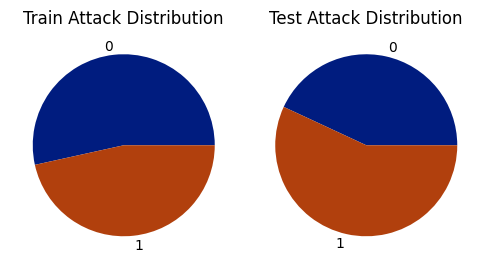

In [222]:

fig, axes = plt.subplots(1, 2, figsize=(5,10))
distribution = train_df["attack"].value_counts().reset_index()
distribution.columns = ["attack", "count"]
distribution.sort_values(by="attack", ascending=True, inplace=True)
print(distribution)

palette_color = sns.color_palette('dark') 
axes[0].pie(data=distribution, labels="attack", x="count", colors=palette_color)
axes[0].set_title("Train Attack Distribution")

distribution = test_df["attack"].value_counts().reset_index()
distribution.columns = ["attack", "count"]
distribution.sort_values(by="attack", ascending=True, inplace=True)
print(distribution)

palette_color = sns.color_palette('dark') 
axes[1].pie(data=distribution, labels="attack", x="count", colors=palette_color)
axes[1].set_title("Test Attack Distribution")


plt.tight_layout()
plt.show()

### Normalise values
Between 0 and 1, except for attack. To avoid vanishing / exploding gradients, normalize the data.

In [223]:
without_attack = train_df.drop(["attack"], axis=1, inplace=False)
normalized_train_df=(without_attack-without_attack.mean())/without_attack.std()
normalized_train_df["attack"] = train_df["attack"]
normalized_train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,attack
0,-0.110249,-0.124706,-0.686782,0.751108,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,...,-0.782364,-0.280281,0.069972,-0.289102,-0.639529,-0.624868,-0.224532,-0.376386,0.216425,0
1,-0.110249,2.219303,0.781424,0.751108,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,...,-1.161026,2.736841,2.367728,-0.289102,-0.639529,-0.624868,-0.387633,-0.376386,-1.965549,0
2,-0.110249,-0.124706,1.087301,-0.736232,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,...,-0.938283,-0.174417,-0.480195,-0.289102,1.608753,1.618949,-0.387633,-0.376386,-0.219969,1
3,-0.110249,-0.124706,-0.442081,0.751108,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095075,...,1.066397,-0.439076,-0.383107,0.066252,-0.572081,-0.602430,-0.387633,-0.345083,0.652820,0
4,-0.110249,-0.124706,-0.442081,0.751108,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095075,...,1.066397,-0.439076,-0.480195,-0.289102,-0.639529,-0.624868,-0.387633,-0.376386,0.652820,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,-0.124706,1.087301,-0.736232,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,...,-0.938283,-0.121485,-0.480195,-0.289102,1.608753,1.618949,-0.387633,-0.376386,0.216425,1
125969,-0.107177,2.219303,1.087301,0.751108,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095075,...,0.977300,-0.386144,-0.447832,-0.289102,-0.639529,-0.624868,-0.387633,-0.376386,0.652820,0
125970,-0.110249,-0.124706,1.393177,0.751108,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095075,...,-0.893735,-0.121485,-0.480195,-0.289102,0.979234,-0.624868,-0.355013,-0.376386,-0.656364,0
125971,-0.110249,-0.124706,-0.075030,-0.736232,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,...,-1.094203,-0.174417,-0.480195,-0.289102,1.608753,1.618949,-0.387633,-0.376386,0.216425,1


In [224]:
without_attack = test_df.drop(["attack"], axis=1, inplace=False)
normalized_test_df=(without_attack-without_attack.mean())/without_attack.std()
normalized_test_df["attack"] = test_df["attack"]
normalized_test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,attack
0,-0.155531,-0.176299,0.933943,-1.829914,-0.021988,-0.096894,-0.017623,-0.059103,-0.019459,-0.113519,...,-1.305341,-0.138367,-0.431847,-0.229975,-0.358110,-0.352742,1.979747,1.929073,0.698310,1
1,-0.155531,-0.176299,0.933943,-1.829914,-0.021988,-0.096894,-0.017623,-0.059103,-0.019459,-0.113519,...,-1.397150,-0.138367,-0.431847,-0.229975,-0.358110,-0.352742,1.979747,1.929073,0.698310,1
2,-0.154109,-0.176299,-0.882235,0.662241,0.005473,-0.096894,-0.017623,-0.059103,-0.019459,-0.113519,...,0.002934,-0.228980,1.559871,0.004234,-0.358110,-0.352742,-0.602706,-0.565471,0.698310,0
3,-0.155531,-2.694991,-1.301353,0.662241,-0.021945,-0.096894,-0.017623,-0.059103,-0.019459,-0.113519,...,0.898070,-0.410208,2.833265,3.048948,-0.358110,-0.352742,-0.602706,-0.565471,-0.706724,1
4,-0.154820,-0.176299,1.632473,-1.518394,-0.021988,-0.096187,-0.017623,-0.059103,-0.019459,-0.113519,...,-0.685632,0.360010,-0.333893,0.004234,-0.358110,-0.352742,1.540730,1.205656,-1.643413,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,-0.155531,-0.176299,1.213355,0.662241,-0.020308,-0.081201,-0.017623,-0.059103,-0.019459,-0.113519,...,0.255408,-0.138367,-0.399195,-0.112871,-0.321498,-0.352742,-0.602706,-0.565471,0.698310,0
22540,-0.155531,-0.176299,-0.672676,0.662241,-0.021317,-0.052689,-0.017623,-0.059103,-0.019459,-0.113519,...,0.898070,-0.410208,-0.399195,-0.112871,-0.321498,-0.352742,-0.602706,-0.565471,0.698310,0
22541,-0.155531,-0.176299,-0.672676,0.662241,0.093371,0.294919,-0.017623,-0.059103,-0.019459,2.040660,...,0.898070,-0.410208,-0.431847,-0.229975,-0.358110,-0.352742,-0.421934,-0.390852,-0.706724,1
22542,-0.155531,2.342392,-1.441059,0.662241,-0.021899,-0.094914,-0.017623,-0.059103,-0.019459,-0.113519,...,0.875118,-0.364901,-0.431847,-0.229975,-0.358110,-0.352742,-0.602706,-0.565471,0.698310,0


## Model

In [225]:
# https://arxiv.org/pdf/1607.00148.pdf
class LSTMAutoEncoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=None):
        super(LSTMAutoEncoder, self).__init__()
        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device
        self.encoder = Encoder(num_layers, hidden_size, nb_feature, dropout, device)
        self.decoder = Decoder(num_layers, hidden_size, nb_feature, dropout, device)

    def forward(self, input_seq):
        output = torch.zeros(size=input_seq.shape, dtype=torch.float, device=self.device)
        encoder_output = self.encoder(input_seq)  

        input_decoder = encoder_output[:, -1, :].unsqueeze(1)
        
        decoder_hidden = (
            torch.randn((self.decoder.num_layers, input_seq.size(0), self.decoder.hidden_size), device=self.device),
            torch.randn((self.decoder.num_layers, input_seq.size(0), self.decoder.hidden_size), device=self.device)
        )
        
        for i in range(input_seq.shape[1] - 1, -1, -1):
            output_decoder, decoder_hidden = self.decoder(input_decoder, decoder_hidden)
            input_decoder = output_decoder
            output[:, i, :] = output_decoder[:, 0, :]
        
        return output

class Encoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(Encoder, self).__init__()
        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True)
        self.hidden_cell = None

    def initHidden(self, batch_size):
        self.hidden_cell = (
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float, device=self.device),
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float, device=self.device)
        )

    def forward(self, input_seq):
        self.initHidden(input_seq.shape[0])
        output, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return output 

class Decoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(Decoder, self).__init__()
        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=nb_feature)

    def forward(self, input_seq, hidden_cell):
        output, hidden_cell = self.lstm(input_seq, hidden_cell)
        output = self.linear(output)
        return output, hidden_cell

# TRAIN

In [226]:
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, device = None, transform=None, target_transform=None):
        self.df_labels = dataframe["attack"]
        self.df = dataframe.drop(["attack"], axis=1, inplace=False)
        self.transform = transform
        self.target_transform = target_transform
        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx]
        label = self.df_labels.iloc[idx]
        tensor_data = torch.tensor(image, device=self.device, dtype=torch.float32).unsqueeze(0)
        tensor_label = torch.tensor(label, device=self.device, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return tensor_data, tensor_label

In [227]:

def calculate_reconstruction_loss(data, model):
    tensor_x = torch.tensor(data, dtype=torch.float32)
    tensor_x = tensor_x.unsqueeze(1)
    reconstructions = model(tensor_x)
    reconstructions = reconstructions.detach().numpy()
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    return np.sum(reconstruction_errors, axis=1)

def train(device, lstm, loss_fn, optimizer, batch_size, loader, verbose=True):
    lstm = lstm.train()
    train_loss = 0
    with torch.autograd.set_detect_anomaly(True):
        for batch, (X, y) in enumerate(loader):
            X, _ = X.to(device), y.to(device)
        # Compute prediction error
            pred = lstm(X)
            loss = loss_fn(pred, X)

        # Backpropagation

            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            if (batch % 100 == 0) and verbose:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{batch_size:>5d}]")
    avg_loss = train_loss / len(loader)
    return avg_loss

def test(device, lstm, loss_fn, batch_size, loader, verbose = True):
    lstm = lstm.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(loader):
            X, _ = X.to(device), y.to(device)

            pred = lstm(X)
            loss = loss_fn(pred, X)

            eval_loss += loss.item()
            if (batch % 100 == 0) and verbose:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{batch_size:>5d}]")
    avg_loss = eval_loss / len(loader)
    return avg_loss

def validation(device, lstm, loss_fn, loader):
    lstm = lstm.eval()
    val_loss = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(loader):
            X, _ = X.to(device), y.to(device)
            pred = lstm(X)
            loss = loss_fn(pred, X)
            val_loss += loss.item()
    avg_loss = val_loss / len(loader)
    return avg_loss

In [228]:
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

len_none_attack_samples = len(normalized_test_df[normalized_test_df["attack"]==0])
training_data = CustomDataset(normalized_train_df[normalized_train_df["attack"]==0], device=device)
validiation_data = CustomDataset(normalized_test_df[normalized_test_df["attack"]==0][:len_none_attack_samples//2], device=device)
test_data = CustomDataset(normalized_test_df[normalized_test_df["attack"]==0][len_none_attack_samples//2:], device=device)
validation_dataloader = DataLoader(validiation_data, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [229]:
LEARNING_RATE = 1E-4
lstm_small = LSTMAutoEncoder(nb_feature=41, num_layers=1, hidden_size=25, device=device)
loss_fn = nn.MSELoss()
optimizer_small = torch.optim.Adam(lstm_small.parameters(), lr=LEARNING_RATE)

/tmp/ipykernel_697/2800816161.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tensor_data = torch.tensor(image, device=self.device, dtype=torch.float32).unsqueeze(0)


[0.7976100596176757, 0.6777889545378663, 0.5895839409243466, 0.5356968216075962, 0.5059339796721652, 0.48468817208634773, 0.4678385292345795, 0.45452522266160633, 0.44375158362046346, 0.4348667919432253]
[0.6975251651908222, 0.6303315225890592, 0.5815185285173357, 0.5578648915122214, 0.6092070883728171, 0.5284099512929586, 0.5137847402304607, 0.5022739183255717, 0.49564456953176933, 0.4892648609208041]
0.41054251081751364


<Axes: >

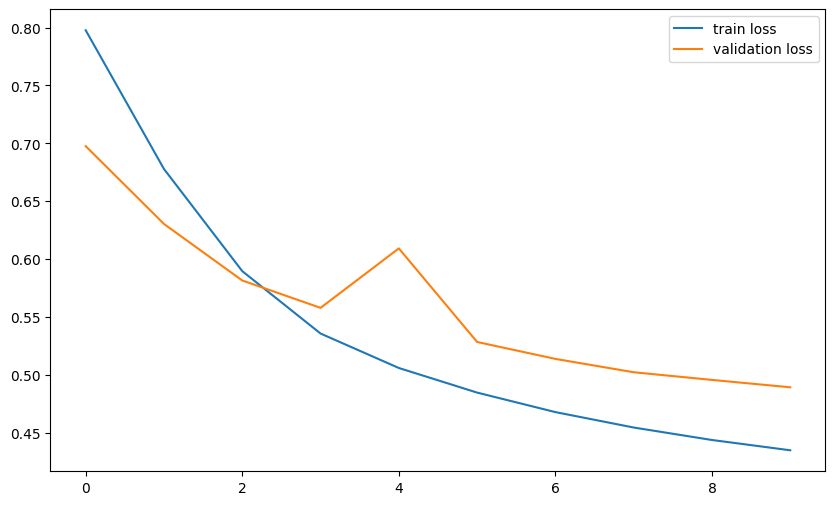

In [230]:
EPOCHS = 10 
train_loss = [0]*EPOCHS
val_loss = [0]*EPOCHS
for i in range(0, EPOCHS):
    train_loss[i] = train(device, lstm_small, loss_fn, optimizer_small, batch_size, train_dataloader, verbose=False)
    val_loss[i] = validation(device, lstm_small, loss_fn, validation_dataloader)
test_loss = test(device, lstm_small, loss_fn, batch_size, test_dataloader, verbose=False)
print(train_loss)
print(val_loss)
print(test_loss)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
x = [i for i in range(0, len(train_loss))]
sns.lineplot(x=x, y=train_loss, ax=ax, label="train loss")
sns.lineplot(x=x, y=val_loss, ax=ax, label="validation loss")

In [231]:
LEARNING_RATE = 1E-4
lstm_high = LSTMAutoEncoder(nb_feature=41, num_layers=1, hidden_size=100, device=device)
loss_fn = nn.MSELoss()
optimizer_high = torch.optim.Adam(lstm_high.parameters(), lr=LEARNING_RATE)

/tmp/ipykernel_697/2800816161.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tensor_data = torch.tensor(image, device=self.device, dtype=torch.float32).unsqueeze(0)


[0.7406912497344322, 0.5365180885636042, 0.45958601273419314, 0.41146751301110923, 0.3788974052640187, 0.35228440566607827, 0.3304745327340629, 0.31234037174783524, 0.2971770806075461, 0.2835831094588509]
[0.6195312396770245, 0.5401394124093809, 0.4920832271516127, 0.46054319934429305, 0.43965141754597425, 0.4230920143891126, 0.4098956053341298, 0.39823309392178136, 0.3895837392253605, 0.3833845671156029]
0.3144467811737406


<Axes: >

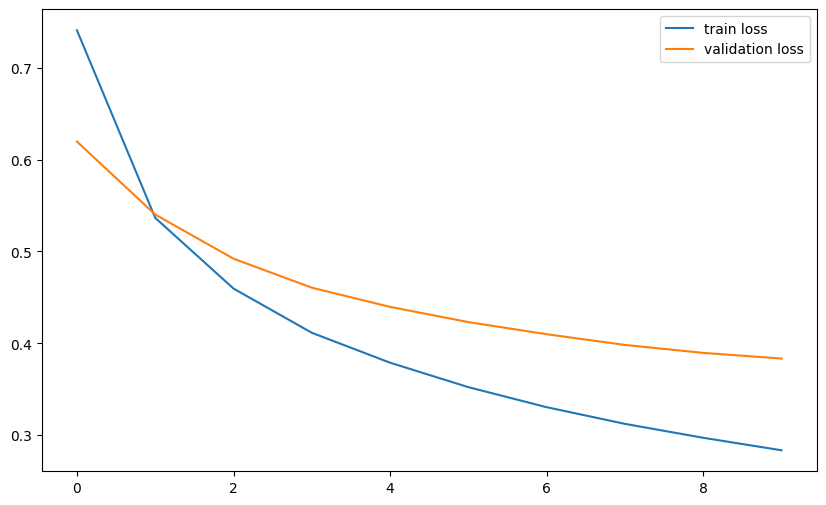

In [232]:
EPOCHS = 10 
train_loss = [0]*EPOCHS
val_loss = [0]*EPOCHS
for i in range(0, EPOCHS):
    train_loss[i] = train(device, lstm_high, loss_fn, optimizer_high, batch_size, train_dataloader, verbose=False)
    val_loss[i] = validation(device, lstm_high, loss_fn, validation_dataloader)
test_loss = test(device, lstm_high, loss_fn, batch_size, test_dataloader, verbose=False)
print(train_loss)
print(val_loss)
print(test_loss)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
x = [i for i in range(0, len(train_loss))]
sns.lineplot(x=x, y=train_loss, ax=ax, label="train loss")
sns.lineplot(x=x, y=val_loss, ax=ax, label="validation loss")

# SGD Classifier


In [233]:
clf = SGDOneClassSVM()
for batch, (X, y) in enumerate(train_dataloader):
    X, _ = X.to(device), y.to(device)
    X = X.squeeze(1)
    clf.partial_fit(X)


/tmp/ipykernel_697/2800816161.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tensor_data = torch.tensor(image, device=self.device, dtype=torch.float32).unsqueeze(0)
/tmp/ipykernel_697/2800816161.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tensor_data = torch.tensor(image, device=self.device, dtype=torch.float32).unsqueeze(0)
/tmp/ipykernel_697/2800816161.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tensor_data

In [234]:
X = np.array(test_df.drop("attack", axis=1, inplace=False))
Y = np.array(test_df["attack"])

In [ ]:
def outlier_target_map(item):
    map = { 
        1:0,
        -1:1
      }
    return map[item] 
pred_y = clf.predict(X)
pred_map = map(outlier_target_map, pred_y)
pred_y = np.array(list(pred_map))
confusion_matrix(Y, pred_y)

In [ ]:
print(f"Accuracy {accuracy_score(Y, pred_y)}")
print(f"Recall {recall_score(Y, pred_y)}")
print(f"Precesion {precision_score(Y, pred_y)}")
print(f"F1 {f1_score(Y, pred_y)}")

Accuracy 0.7160220014194464
Recall 0.7803319566741993
Precesion 0.7364859895565198
F1 0.7577752553916004


LSTM Auto Reconstruction

In [238]:
def predict_outliers_reconstruction(data, model, threshold=None):
    model.eval()
    reconstruction_errors = []

    with torch.no_grad():
        for point in data:
            tensor_x = torch.tensor(point, dtype=torch.float32).unsqueeze(0).unsqueeze(0) 
            reconstruction = model(tensor_x)
            reconstruction = reconstruction.squeeze().numpy() 
            error = np.mean(np.abs(point - reconstruction)) 
            reconstruction_errors.append(error)

    if threshold is None:
        # Default: use a threshold based on percentiles
        threshold = np.percentile(reconstruction_errors, 95)

    predictions = [1 if e > threshold else 0 for e in reconstruction_errors]

    return predictions, reconstruction_errors, threshold

In [239]:
pred_y, _, _ = predict_outliers_reconstruction(X, lstm_high)
print(f"Accuracy {accuracy_score(Y, pred_y)}")
print(f"Recall {recall_score(Y, pred_y)}")
print(f"Precesion {precision_score(Y, pred_y)}")
print(f"F1 {f1_score(Y, pred_y)}")

Accuracy 0.47112313697657915
Recall 0.0794046598612951
Precesion 0.9033687943262412
F1 0.14597808179929805


In [240]:
pred_y, _, _ = predict_outliers_reconstruction(X, lstm_small)
print(f"Accuracy {accuracy_score(Y, pred_y)}")
print(f"Recall {recall_score(Y, pred_y)}")
print(f"Precesion {precision_score(Y, pred_y)}")
print(f"F1 {f1_score(Y, pred_y)}")

Accuracy 0.47112313697657915
Recall 0.0794046598612951
Precesion 0.9033687943262412
F1 0.14597808179929805


# Combiniation

In [241]:
clf = KNeighborsClassifier()
X = np.array(test_df.drop("attack", axis=1, inplace=False))
Y = np.array(test_df["attack"])

tensor_x = torch.tensor(X, dtype=torch.float32)
tensor_x = tensor_x.unsqueeze(1)
X = lstm_small.encoder(tensor_x)
X = X.squeeze(1)
X = X.detach().numpy()
clf.fit(X, Y)


KNeighborsClassifier()

In [242]:

pred_y = clf.predict(X)
print(f"Accuracy {accuracy_score(Y, pred_y)}")
print(f"Recall {recall_score(Y, pred_y)}")
print(f"Precesion {precision_score(Y, pred_y)}")
print(f"F1 {f1_score(Y, pred_y)}")


Accuracy 0.9020581973030518
Recall 0.9302579287773708
Precesion 0.9009131386310467
F1 0.9153504063793897


In [243]:
ab = [0, 0]
for i in pred_y:
    ab[i] += 1
ab

[9293, 13251]